<a href="https://colab.research.google.com/github/trekkateer/jcn6-CS-375/blob/main/notebooks/3B-Notebook-for-Sklearn-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification in `scikit-learn`

Goals:

- Practice with the `fit` and `predict` interface of sklearn models
- Compare and contrast regression and classification as machine learning tasks
- Practice interpreting cross-entropy loss

## Setup

Much of this setup is the same as the regression notebook.

Let's import necessary modules: Pandas and NumPy for data wrangling, Matplotlib for plotting, and some sklearn models.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, log_loss, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

We'll load the data. We're using a dataset of home sale prices from the Ames, Iowa assessor's database, described in [this paper](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf).

In [91]:
ames = pd.read_csv('https://github.com/kcarnold/AmesHousing/blob/master/data/ames.csv.gz?raw=true', compression="gzip")
ames['price'] = ames["Sale_Price"] / 100_000 # Make `price` be in units of $100k, to be easier to interpret.
ames.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude,price
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,NaN,0,5,2010,WD,Normal,215000,-93.619754,42.054035,2.150
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,NaN,0,6,2010,WD,Normal,105000,-93.619756,42.053014,1.050
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659,1.720
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,NaN,0,4,2010,WD,Normal,244000,-93.617320,42.051245,2.440
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,NaN,0,3,2010,WD,Normal,189900,-93.638933,42.060899,1.899


We'll try to predict home price based on *location* (which the realtors assure us is the most important factor anyway). So we'll grab the Latitude and Longitude columns of the data. We'll call that input data `X`, by convention.

In [92]:
X = ames[['Longitude', 'Latitude']].values
X.shape

(2930, 2)

We'll do something different for `y`; see below.

## Task

Notice that the distribution of sale prices is skewed.

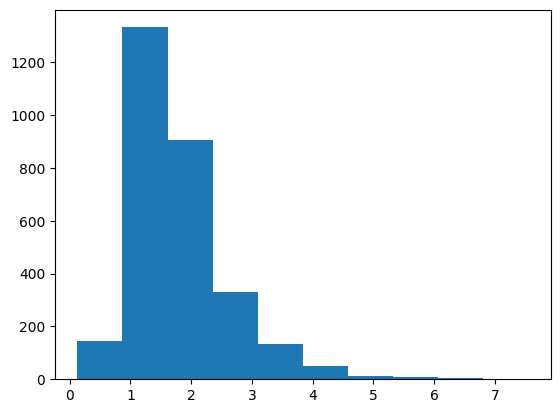

In [93]:
plt.hist(ames.price);

Skew can make regression hard because errors in the tails (in this case, the expensive houses) can dominate: mispredicting a million-dollar home by 1% is as bad as mispredicting a \$100k home by 10%!

One way to resolve this is to transform the target variable to be more evenly distributed. (For example, a log transformation will make all percentage errors equally important.) Another way is to transform it into a *classification* problem, where we predict whether the home price is *low*, *medium*, or *high*. We'll skip lots of nuance here and just split the prices into 3 equal buckets.

In [94]:
# This is some Pandas trickery. Enjoy, those who dare venture here! Otherwise don't worry about it.
ames['price_rank'] = ames.price.rank(pct=True)
ames['price_bin'] = 0 + (ames.price_rank > 1/3) + (ames.price_rank > 2/3)
ames.price_bin.value_counts()

,count
price_bin,
0,981
1,980
2,969


**Make a target `y` using the `price_bin` column of `ames`.**

In [123]:
y = ames['price_bin'].values
y

array([2, 0, 1, ..., 0, 1, 1])

**Split the data (`X` and `y`) into a training and validation set** using the same fraction and seed as the previous notebook.

In [157]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

We could use the plotting mechanism we used for regression in the previous notebook (try it, it does work), but it's a bit confusing because the model will be predicting 0, 1, or 2, while the data is in the original range. That would also omit one cool thing we gain by moving to a classifier: we get *probabilities*! You can interpret that as the model's *confidence* about a home price prediction. We could do this with regression too, but it's more complex; it comes for free with classification.

Here we define the new plotting function; don't worry about how it works.

In [158]:
def plot_class_probs(clf):
    lat_min = ames.Latitude.min()
    lat_max = ames.Latitude.max()
    lon_min = ames.Longitude.min()
    lon_max = ames.Longitude.max()

    xx, yy = np.meshgrid(np.linspace(lon_min, lon_max, 500), np.linspace(lat_min, lat_max, 500))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    n_classes = Z.shape[1]
    fig, axs = plt.subplots(ncols=n_classes, figsize=(16, 6), sharey=True)
    for i, ax in enumerate(axs):
        contour = ax.contourf(xx, yy, Z[:, i].reshape(xx.shape), alpha=.5, cmap=plt.cm.RdBu_r)#, vmin=0., vmax=1.)
        ax.scatter(ames['Longitude'], ames['Latitude'], s=.5, color='k')
        ax.set(title=f"Class {i} probabilities", xlabel="Longitude")
    axs[0].set(ylabel="Latitude")
    fig.colorbar(contour, ax=ax, fraction=.05)

### Part A: Logistic Regression

Logistic regression is a classification algorithm, despite the name! It's the classifier version of linear regression.

**Fit a logistic regression model (call it `logreg`) to our training set (`X_train` and `y_train`).**

In [167]:
logreg = LogisticRegression(random_state=42).fit(X_train, y_train)

Let's plot the class probabilities. Notice the range of values (in the color bar). What do you think the model will classify homes in the northwest (top left) corner as?

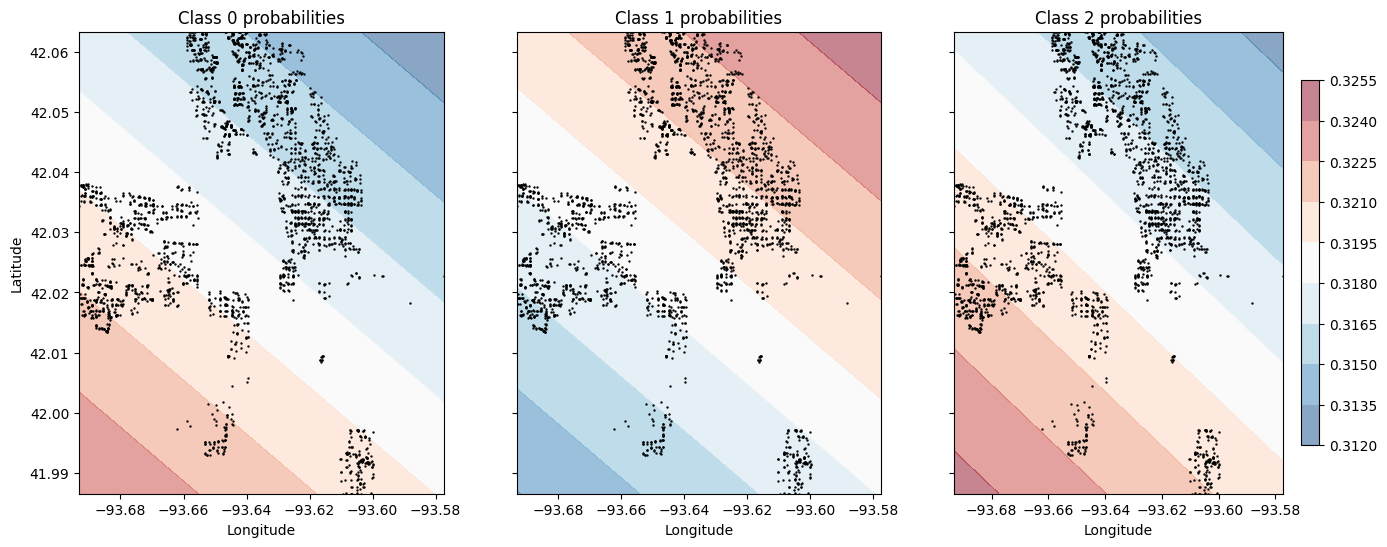

In [162]:
plot_class_probs(logreg)

**Compute the accuracy and categorical cross-entropy loss** on the validation set. You'll need to:

1. Use the classifier `clf` to compute the predicted classes.
2. Use `accuracy_score` and `log_loss`. to compute the loss values. Look these up in the sklearn documentation if you need to.

You'll need to use `predict_proba` for one of these (which one?) to ask the classifier to tell you its probabilities, not just its best guess.

Note: *categorical cross-entropy loss* is also known as *log loss*; think about why.

In [171]:
def summarize_classifier(clf, X_valid, y_valid):
    y_pred = clf.predict(X_valid)
    print("Accuracy: {:.3f}".format(accuracy_score(y_valid, y_pred)))
    print("Log loss: {:.3f}".format(log_loss(y_valid, y_pred, labels = [0,1])))
summarize_classifier(logreg, X_valid, y_valid)

Accuracy: 0.314
Log loss: 11.010


### Part B: Decision tree classifier

**Fit a decision tree classifier (call it `dtree_clf`) to the training set**. Use the default hyperparameters.

In [143]:
dtree_clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

Let's plot the probabilities for this classifier.

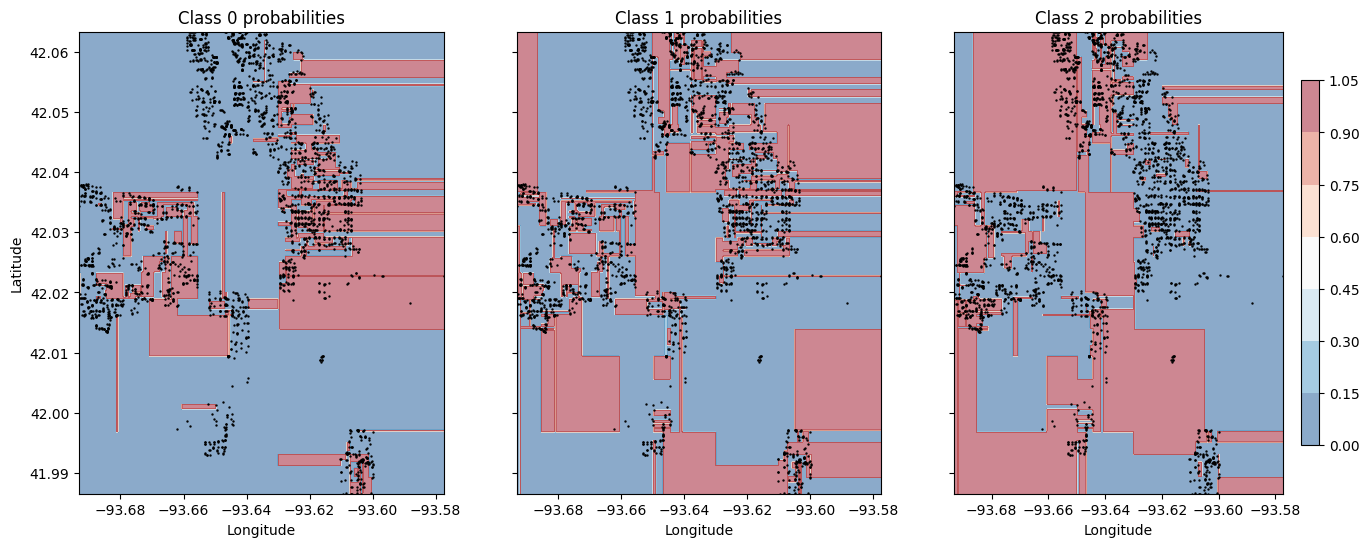

In [144]:
plot_class_probs(dtree_clf)

**Compute the accuracy and cross-entropy loss**. Be careful to use the correct classifier each time!

In [145]:
summarize_classifier(dtree_clf, X_valid, y_valid)

Accuracy: 0.705
Log loss: 6.520


Note: you might see slightly different numbers from these because of randomness in the training process. That's okay. (If multiple possible splitting criteria would be equally good, sklearn will choose randomly.)

### Part C: Random Forest

A random forest consists of many different decision trees, but:

1. Each tree only gets a random subset of the training data
2. Each time the tree splits, it only gets to look at a random subset of the features. (We're only using two features overall, so this doesn't make much difference.)

To make a decision, it averages the decisions of each tree. (This means it's an "ensemble" method.)

The net effect is that an RF can fit the data well (since each tree is a pretty good predictor) but it tends not to *overfit* because it averages the predictions of trees trained on different subsets of data.

Let's try it.

**Fit a random forest classifier to the training set.**

If you want to compare your results with the reference notebook, use `random_state=42` as a parameter to the classifier.

In [172]:
rf_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

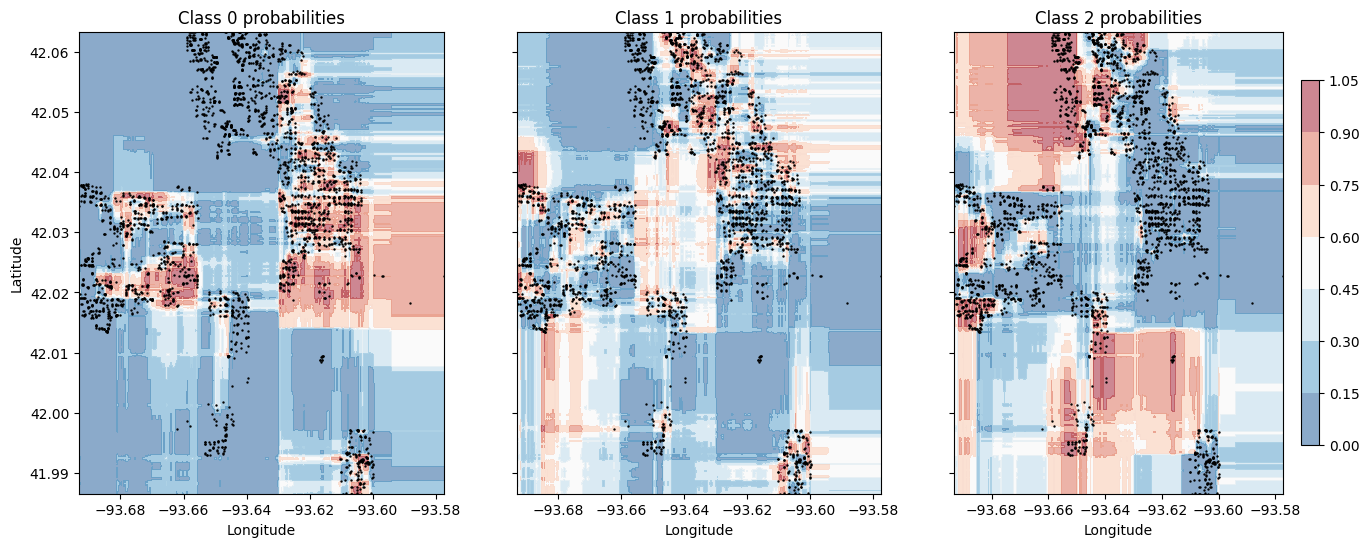

In [173]:
plot_class_probs(rf_clf)

**Compute the accuracy and cross-entropy loss**. Be careful to use the correct classifier each time!

In [174]:
summarize_classifier(rf_clf, X_valid, y_valid)

# Accuracy: 0.749
# Log loss: 0.867

Accuracy: 0.746
Log loss: 5.105


## Analysis

**How does the accuracy compare between the three classifiers?**

*The accuracy is highest for the random forest classifier, with a score of 0.749 vs. 0.705 for the decision tree and 0.314 for the logistic regression classifier.*

**How does the cross-entropy loss compare between the three classifiers?** Why is the ranking different for this loss compared with accuracy? Look at the actual values. Hint:

In [ ]:
-np.log(1/3)

np.float64(1.0986122886681098)

*The cross entropy loss is highest for the logistic regression classifier, and lowest for the random forest. This ranking is different from accuracy mainly because it captures the __loss__ of the model rather than the number of classifications it got right.*

**Describe, qualitatively, the shapes that each classifier makes in its class probability plots.** Explain how the accuracy and cross-entropy numbers make sense in light of these plots.

*your narrative answer here*

**Which of these classifiers *overfit*? Which ones *underfit*?**

*your narrative answer here*

## Extension

*optional*

1. Compute the loss on the *training* set for each of these classifiers. Can that help you tell whether your classifier overfit or not?
2. Try using more features in the dataset. How well can you classify? Be careful about *categorical* features.